In [1]:
import os,sys
sys.path.insert(0, '/home/gridsan/swamiviv/projects/generative_uncertainty/pixel2style2pixel')
sys.path.insert(0, '/home/gridsan/swamiviv/projects/generative_uncertainty/stylegan2-pytorch')

import os
from argparse import Namespace
import time
import sys
import pprint
import numpy as np
from PIL import Image
import torch
import torchvision.transforms as transforms

sys.path.append(".")
sys.path.append("..")

from datasets import augmentations
from utils.common import tensor2im, log_input_image
from models.psp import pSp, get_keys
from models.encoders import psp_encoders


import cv2
import matplotlib.pyplot as plt
from train_utils import mixing_noise
from model import Generator
%matplotlib inline

%load_ext autoreload
%autoreload 2

device='cuda'

/home/gridsan/swamiviv/projects/generative_uncertainty/stylegan2-pytorch/op


In [ ]:
model_to_load = '/home/gridsan/swamiviv/experimental_logs/generative_uncertainty/quantile_GAN/dry_runs/checkpoints/iteration_85000.pt'
ckpt = torch.load(model_to_load, map_location='cuda:0')
encoder_opts = ckpt['opts']
encoder_opts['checkpoint_path'] = model_to_load
encoder_net = psp_encoders.GradualStyleEncoder_with_quantiles(50, 'ir_se', Namespace(**encoder_opts))
d = get_keys(ckpt, '')
    

In [14]:
ls -l /home/gridsan/swamiviv/experimental_logs/generative_uncertainty/quantile_GAN/psp_superres_feature_to_ss_direct_all_res_quantile_mask/logs/images/train/faces/ | tail -n 5

-rw-rw---- 1 swamiviv swamiviv 126272 Dec 20 14:06 128250.jpg
-rw-rw---- 1 swamiviv swamiviv 110260 Dec 20 14:08 128500.jpg
-rw-rw---- 1 swamiviv swamiviv 114935 Dec 20 14:10 128750.jpg
-rw-rw---- 1 swamiviv swamiviv 108882 Dec 20 14:11 129000.jpg
-rw-rw---- 1 swamiviv swamiviv 122945 Dec 20 14:13 129250.jpg


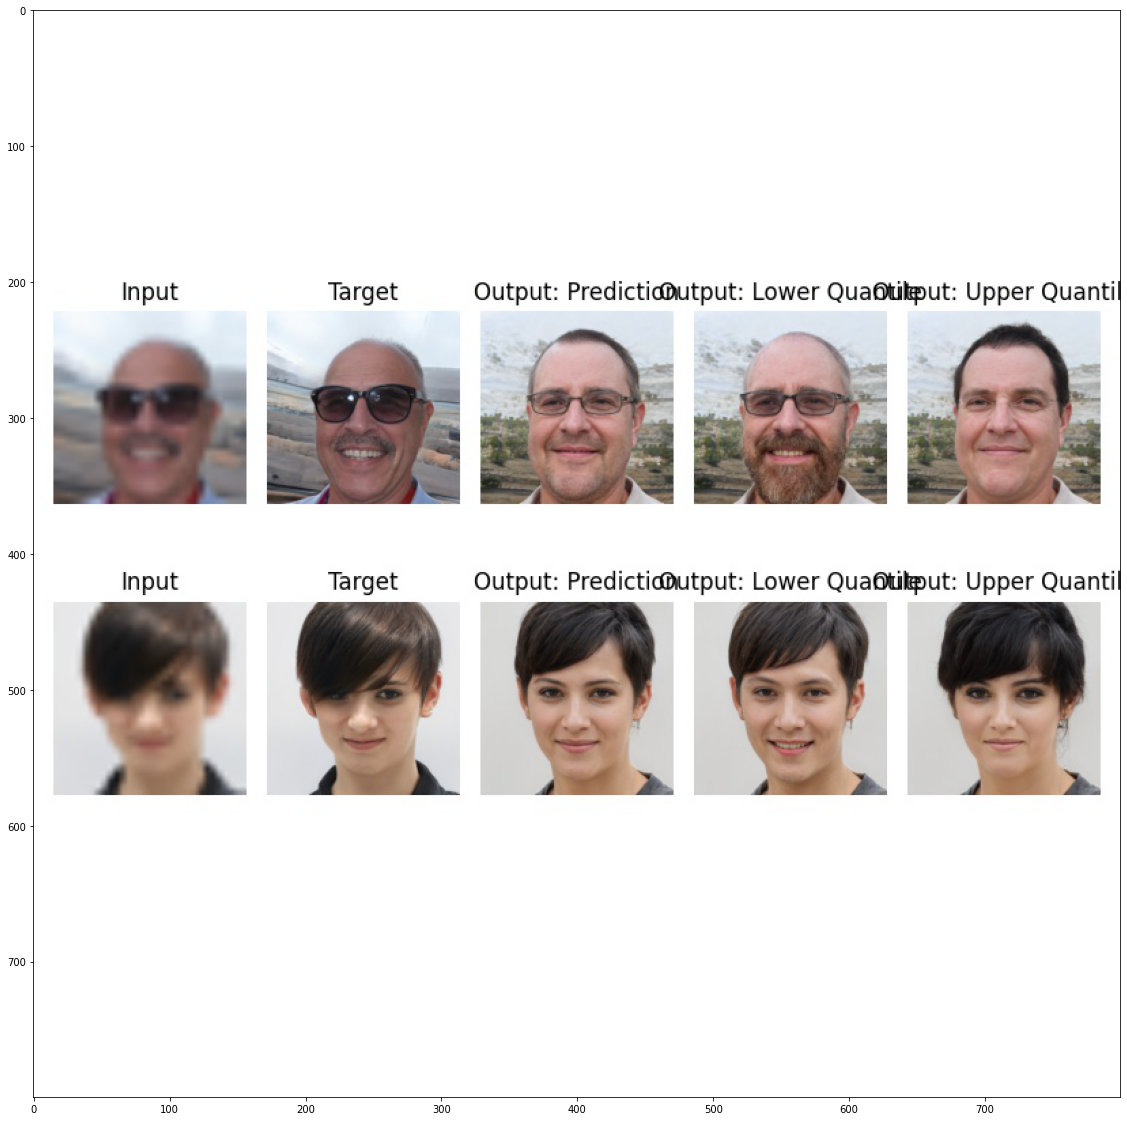

In [15]:
im = plt.imread('/home/gridsan/swamiviv/experimental_logs/generative_uncertainty/quantile_GAN/psp_superres_feature_to_ss_direct_all_res_quantile_mask/logs/images/train/faces/128500.jpg')
plt.figure(figsize=(20, 20))
plt.imshow(im)

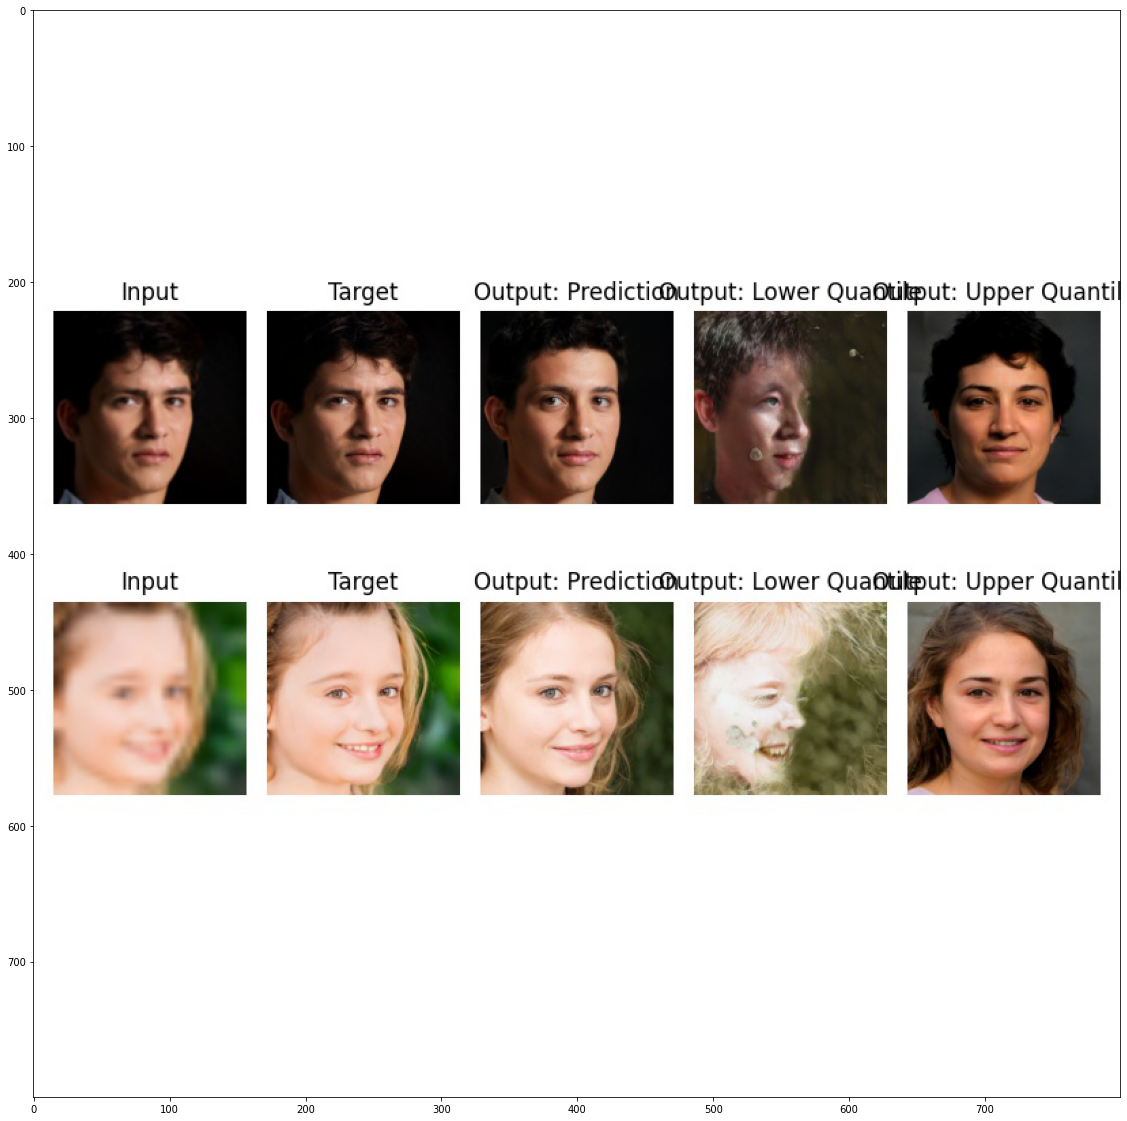

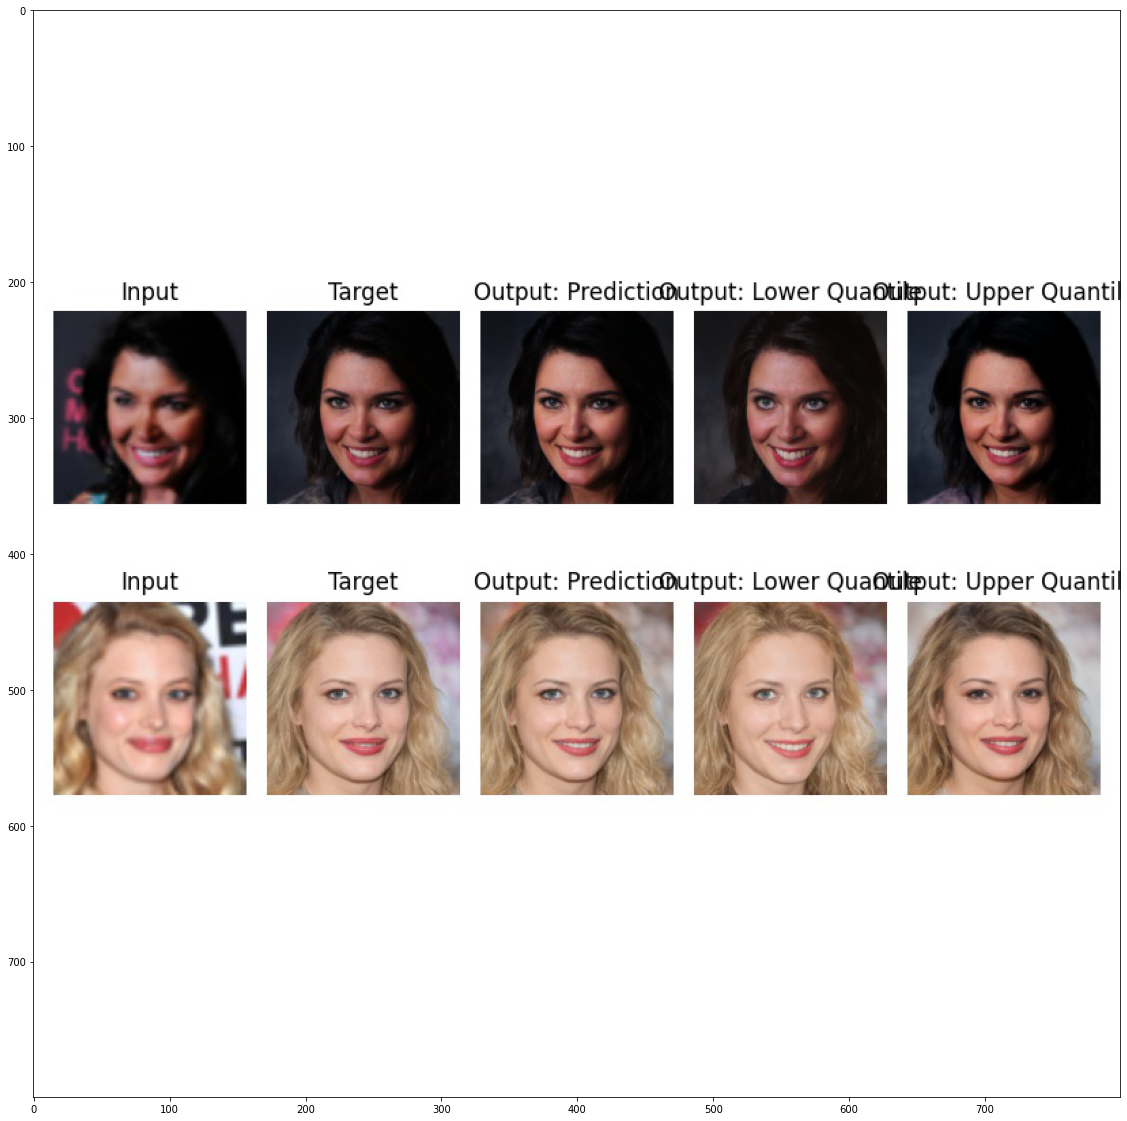

In [85]:
label_list = ['skin', 'nose', 'eye_g', 'l_eye', 'r_eye', 'l_brow', 'r_brow', 'l_ear', 'r_ear', 'mouth', 'u_lip', 'l_lip', 'hair', 'hat', 'ear_r', 'neck_l', 'neck', 'cloth']
color_list = [[0, 0, 0], [204, 0, 0], [76, 153, 0], [204, 204, 0], [51, 51, 255], [204, 0, 204], [0, 255, 255], [255, 204, 204], [102, 51, 0], [255, 0, 0], [102, 204, 0], [255, 255, 0], [0, 0, 153], [0, 0, 204], [255, 51, 153], [0, 204, 204], [0, 51, 0], [255, 153, 51], [0, 204, 0]]

folder_base = '/home/gridsan/swamiviv/datasets/CelebAMask-HQ/CelebAMask-HQ/CelebAMask-HQ-mask-anno'
folder_save = '/home/gridsan/swamiviv/datasets/CelebAMask-HQ/CelebAMask-HQ/CelebAMask-HQ-mask'
img_num = 1

for k in range(2):
    folder_num = k // 2000
    im_base = np.zeros((512, 512))
    im_color = np.zeros((512, 512, 3))
    for idx, label in enumerate(label_list):
        filename = os.path.join(folder_base, str(folder_num), str(k).rjust(5, '0') + '_' + label + '.png')
        if (os.path.exists(filename)):
            print (label, idx+1)
            im = cv2.imread(filename)
            im = im[:, :, 0]
            im_base[im != 0] = (idx + 1)
Image.fromarray(im_base.astype(np.uint8)).save('sample_input_mask.png')

skin 1
nose 2
l_eye 4
r_eye 5
l_brow 6
r_brow 7
mouth 10
u_lip 11
l_lip 12
hair 13
neck 17
skin 1
nose 2
l_eye 4
r_eye 5
l_brow 6
r_brow 7
l_ear 8
r_ear 9
mouth 10
u_lip 11
l_lip 12
hair 13
neck 17
cloth 18


In [86]:
import pandas as pd
image_list = pd.read_csv('/home/gridsan/swamiviv/datasets/CelebAMask-HQ/CelebAMask-HQ/CelebA-HQ-to-CelebA-mapping.txt', delim_whitespace=True, header=None)[1:]
train_df = pd.DataFrame()
val_df = pd.DataFrame()
test_df = pd.DataFrame()

for row in image_list.iterrows():
    x = int(row[1][1])
    if x >= 162771 and x < 182638:
        val_df = val_df.append(pd.DataFrame(row[1]).T, ignore_index=True)
    elif x >= 182638:
        test_df = test_df.append(pd.Series(row), ignore_index=True)
    else:
        train_df = train_df.append(pd.Series(row), ignore_index=True)
        

In [21]:
# experiment_type = 'celebs_seg_to_face'
EXPERIMENT_ARGS = {
    "model_path": "../../pretrained_models/psp_celebs_seg_to_face.pt",
    "image_path": "/home/gridsan/swamiviv/datasets/CelebAMask-HQ/CelebAMask-HQ/CelebAMask-HQ-mask/train/12/25991.png",
    "transform": transforms.Compose([
        transforms.Resize((256, 256)),
        augmentations.ToOneHot(n_classes=19),
        transforms.ToTensor()])
}
model_path = EXPERIMENT_ARGS['model_path']
ckpt = torch.load(model_path, map_location='cuda:0')
opts = ckpt['opts']
pprint.pprint(opts)
latent_avg = ckpt['latent_avg'].to('cuda:0')
print(latent_avg.shape)

{'batch_size': 8,
 'board_interval': 50,
 'checkpoint_path': None,
 'dataset_type': 'celebs_seg_to_face',
 'device': 'cuda:0',
 'encoder_type': 'GradualStyleEncoder',
 'exp_dir': '',
 'id_lambda': 0.0,
 'image_interval': 100,
 'input_nc': 19,
 'l2_lambda': 1.0,
 'l2_lambda_crop': 0,
 'label_nc': 19,
 'learn_in_w': False,
 'learning_rate': 0.0001,
 'lpips_lambda': 0.8,
 'lpips_lambda_crop': 0,
 'max_steps': 80000,
 'optim_name': 'ranger',
 'resize_factors': None,
 'save_interval': 10000,
 'start_from_latent_avg': True,
 'stylegan_weights': '',
 'test_batch_size': 8,
 'test_workers': 8,
 'train_decoder': False,
 'val_interval': 5000,
 'w_norm_lambda': 0.005,
 'workers': 8}
torch.Size([18, 512])


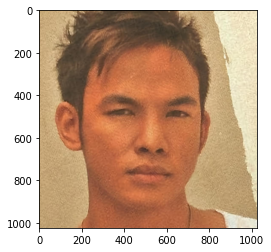

In [88]:
im = plt.imread('/home/gridsan/swamiviv/datasets/CelebAMask-HQ/CelebAMask-HQ/CelebA-HQ-img/28570.jpg')
plt.imshow(im)

In [22]:
# update the training options
opts['checkpoint_path'] = model_path
if 'learn_in_w' not in opts:
    opts['learn_in_w'] = False
if 'output_size' not in opts:
    opts['output_size'] = 1024
    
opts = Namespace(**opts)
net = pSp(opts)
net.eval()
net.cuda()
print('Model successfully loaded!')
opts

Loading pSp from checkpoint: ../../pretrained_models/psp_celebs_seg_to_face.pt
Model successfully loaded!


Namespace(batch_size=8, board_interval=50, checkpoint_path='../../pretrained_models/psp_celebs_seg_to_face.pt', dataset_type='celebs_seg_to_face', device='cuda:0', encoder_type='GradualStyleEncoder', exp_dir='', id_lambda=0.0, image_interval=100, input_nc=19, l2_lambda=1.0, l2_lambda_crop=0, label_nc=19, learn_in_w=False, learning_rate=0.0001, lpips_lambda=0.8, lpips_lambda_crop=0, max_steps=80000, n_styles=18, optim_name='ranger', output_size=1024, resize_factors=None, save_interval=10000, start_from_latent_avg=True, stylegan_weights='', test_batch_size=8, test_workers=8, train_decoder=False, val_interval=5000, w_norm_lambda=0.005, workers=8)

In [23]:
from models.encoders import psp_encoders

E = psp_encoders.GradualStyleEncoder_with_quantiles(50, mode='ir_se', opts=opts)
E = E.to(device)
mask_input = torch.randn((4, 19, 256, 256)).float().to(device)
a= E(mask_input)
print(a.shape)

torch.Size([4, 3, 18, 512])


In [36]:
E.styles_uq[-1].linear.weight.sum()

tensor(-245.3860, device='cuda:0', grad_fn=<SumBackward0>)

(256, 256) [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]


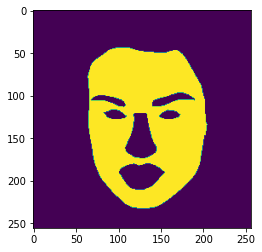

In [54]:
image_path = EXPERIMENT_ARGS["image_path"]
original_image = cv2.imread(image_path, 0)
original_image = cv2.resize(original_image, (256, 256), cv2.INTER_CUBIC)
print(original_image.shape, np.unique(original_image))
plt.imshow(original_image == 1)
plt.show()

In [55]:
def get_multi_modal_outputs(input_image, vectors_to_inject):
    results = []
    print(input_image.sum())
    with torch.no_grad():
        for vec_to_inject in vectors_to_inject:
          cur_vec = torch.from_numpy(vec_to_inject).unsqueeze(0).to("cuda")
          # get latent vector to inject into our input image
          _, latent_to_inject = net(cur_vec,
                                    input_code=True,
                                    return_latents=True)
          # get output image with injected style vector
          res, latent = net(input_image.unsqueeze(0).to("cuda").float(),
                    latent_mask=latent_mask,
                    inject_latent=latent_to_inject,
                    alpha=mix_alpha,
                   return_latents=True)
          results.append(res[0])
          print(f'Output latent shape: {latent.shape}')
          print(latent.sum(axis=-1))
    return results

torch.Size([19, 256, 256]) tensor(0) tensor(1)
tensor([[48.3346, 45.5839, 34.5535, 37.6914, 46.8381, 48.5086, 45.7722, 44.3654,
         33.4218, 40.5097, 46.4349, 48.8337, 47.3969, 45.6893, 49.1743, 47.8041,
         46.9692, 50.9401]], device='cuda:0', grad_fn=<SumBackward1>)
torch.Size([1, 3, 1024, 1024]) torch.Size([1, 18, 512])


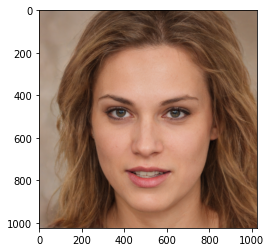

In [121]:
input_image = Image.fromarray(original_image.astype(np.uint8))
img_transforms = EXPERIMENT_ARGS['transform']
transformed_image = img_transforms(input_image)
print(transformed_image.shape, transformed_image.min(), transformed_image.max())
codes = net.encoder(transformed_image.unsqueeze(0).to("cuda").float())

codes_with_avg = codes + latent_avg
print(codes_with_avg.sum(axis=-1))

with torch.no_grad():
    #output, latents = net(transformed_image.unsqueeze(0).to("cuda").float(), return_latents=True, resize=False)
    output, latents = net.decoder([codes_with_avg], input_is_latent=True, randomize_noise=True, return_latents=True)
print(output.shape, latents.shape)
output = (output + 1) * 127.5
output[output > 255] = 255
output[output < 0 ] = 0
plt.imshow(output.detach().cpu().numpy().squeeze().transpose((1, 2, 0)).astype(np.uint8))
# codes_np = codes.detach().cpu().numpy()
# print(np.linalg.norm(codes_np, axis=-1))

# device = 'cuda'
# noise = mixing_noise(32, 512, 0.9, device)
# print(noise[1].shape)
# generator = Generator(
#         128, 512, 8, 4,
#     ).to(device)
# out = generator(noise)
# print(out[0].shape)

torch.Size([19, 256, 256]) tensor(0) tensor(1)
tensor([[48.3346, 45.5839, 34.5535, 37.6914, 46.8381, 48.5086, 45.7722, 44.3654,
         33.4218, 40.5097, 46.4349, 48.8337, 47.3969, 45.6893, 49.1743, 47.8041,
         46.9692, 50.9401]], device='cuda:0', grad_fn=<SumBackward1>)
tensor([[48.3346, 45.5839, 34.5535, 37.6914, 46.8381, 48.5086, 45.7722, 44.3654,
         33.4218, 40.5097, 46.4349, 48.8337, 47.3969, 45.6893, 49.1743, 47.8041,
         46.9692, 50.9401]], device='cuda:0') True True True True
Before resize:  torch.Size([1, 3, 1024, 1024]) tensor([[ 134990.9062, -190581.1250, -371936.1250]], device='cuda:0')
After resize:  torch.Size([1, 3, 256, 256]) tensor([[  8436.9316, -11911.3203, -23246.0078]], device='cuda:0')
torch.Size([1, 3, 256, 256]) torch.Size([1, 18, 512])


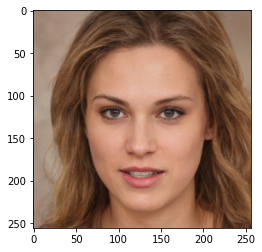

In [100]:
#

input_image = Image.fromarray(original_image.astype(np.uint8))
img_transforms = EXPERIMENT_ARGS['transform']
transformed_image = img_transforms(input_image)
latent_mask = None #[8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
mix_alpha = None

n_outputs_to_generate = 8
# randomly draw the latents to use for style mixing
vectors_to_inject = np.random.randn(n_outputs_to_generate, 512).astype('float32')
multi_results = get_multi_modal_outputs(transformed_image, vectors_to_inject)
len(multi_results), multi_results[0].shape

tensor(65536)
Input shape:  torch.Size([1, 19, 256, 256])
After input_layer mapping:  torch.Size([1, 64, 256, 256])
Feature pyramid shapes:  torch.Size([1, 128, 64, 64]) torch.Size([1, 256, 32, 32]) torch.Size([1, 512, 16, 16])
Output latent shape: torch.Size([1, 18, 512])
tensor([[48.3346, 45.5839, 34.5535, 37.6914, 46.8381, 48.5086, 45.7722, 44.3654,
         33.4218, 40.5097, 46.4349, 48.8337, 47.3969, 45.6893, 49.1743, 47.8041,
         46.9692, 50.9401]], device='cuda:0')
Input shape:  torch.Size([1, 19, 256, 256])
After input_layer mapping:  torch.Size([1, 64, 256, 256])
Feature pyramid shapes:  torch.Size([1, 128, 64, 64]) torch.Size([1, 256, 32, 32]) torch.Size([1, 512, 16, 16])
Output latent shape: torch.Size([1, 18, 512])
tensor([[48.3346, 45.5839, 34.5535, 37.6914, 46.8381, 48.5086, 45.7722, 44.3654,
         33.4218, 40.5097, 46.4349, 48.8337, 47.3969, 45.6893, 49.1743, 47.8041,
         46.9692, 50.9401]], device='cuda:0')
Input shape:  torch.Size([1, 19, 256, 256])
After 

(8, torch.Size([3, 256, 256]))

In [43]:
from mpl_toolkits.axes_grid1 import ImageGrid

input_vis_image = log_input_image(transformed_image, opts)
#res = np.array(input_vis_image.resize((256, 256)))
res = []
input_vis_image_np = np.asarray(input_vis_image)
fg_mask = np.array(np.where((input_vis_image_np > 0), np.ones(input_vis_image_np.shape), np.zeros(input_vis_image_np.shape)))
#fg_mask = np.ones(input_vis_image_np.shape)
outputs = [input_vis_image_np[None, :, :, :]]
for output in multi_results:
    output = tensor2im(output) 
    output = np.array(output.resize((256, 256)))
    outputs.append(output[None, :, :, :])
    if res == []:
        res = output
    else:
        res = np.concatenate([res, output], axis=1)
    
# print(res.shape, res.min())

# outputs_np = np.vstack(outputs)[:, :, :, 0].squeeze().astype(np.float32)
# print(outputs_np.shape)

# output_mean = np.mean(outputs_np[1:, :, :], axis=(1, 2))
# output_var = np.std(outputs_np[1:, :, :], axis=0)
# output_var = output_var * fg_mask[:, :, 0]
# output_var_rgb = np.zeros(input_vis_image_np.shape)
# output_var_rgb[:, :, 0] = output_var
# output_var_rgb[:, :, 1] = output_var
# output_var_rgb[:, :, 2] = output_var
# outputs.append(output_var_rgb)
# # res_image = Image.fromarray(res.astype(np.uint8))
# # res_image
# fig = plt.figure(figsize=(30., 30.))
# grid = ImageGrid(fig, 111,  # similar to subplot(111)
#                  nrows_ncols=(1, 10),  # creates 2x2 grid of axes
#                  axes_pad=0.05,  # pad between axes in inch.
#                  )
# i = 0
# for ax, im in zip(grid, outputs):
#     # Iterating over the grid returns the Axes.
#     ax.imshow(im.squeeze().astype(np.uint8))
#     if i == 0:
#         ax.set_title('Input: seg map')
#     elif i == len(outputs) - 1:
#         ax.set_title('Pixelwise variance')
#     else:
#         ax.set_title(f'Output: Sample {i}')
#     i+=1

# plt.show()

/home/gridsan/swamiviv/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  


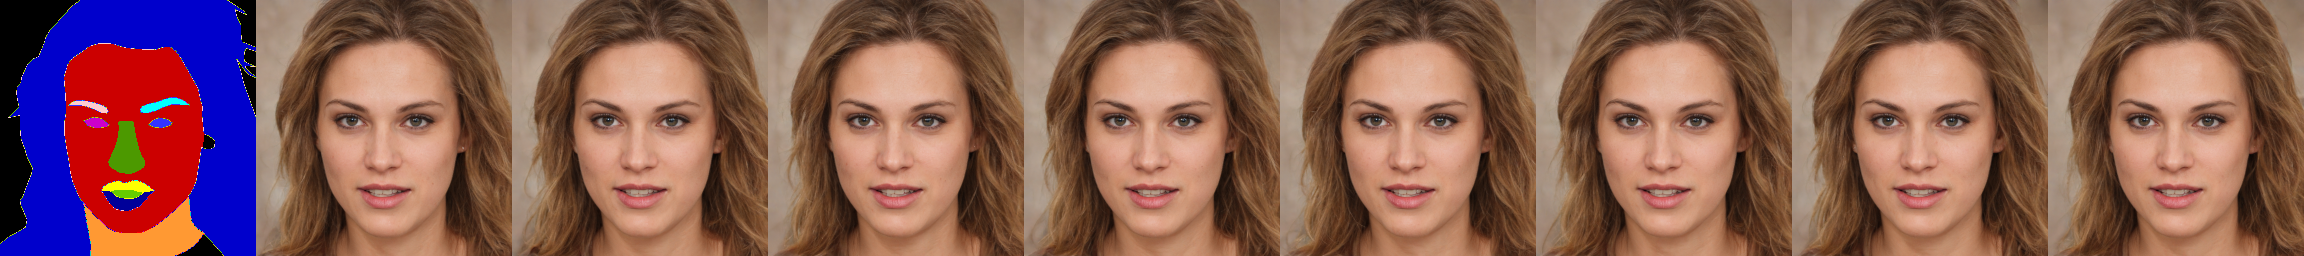

In [101]:
input_vis_image = log_input_image(transformed_image, opts)
res = np.array(input_vis_image.resize((256, 256)))
for output in multi_results:
    output = tensor2im(output)
    res = np.concatenate([res, np.array(output.resize((256, 256)))], axis=1)
res_image = Image.fromarray(res)
res_image

(256, 256, 3) (256, 256, 3)


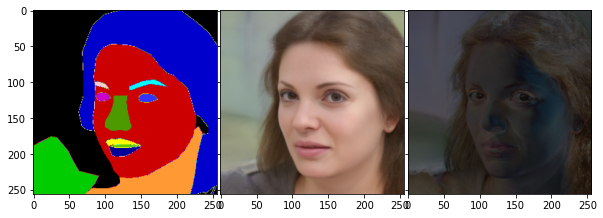

In [65]:
outputs_np = np.vstack(outputs[1:])
outputs_np.shape
output_mean = np.mean(outputs_np, axis=0)
output_std = np.std(outputs_np, axis=0)
print(output_mean.shape, output_std.shape)
fig = plt.figure(figsize=(10., 10.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
    nrows_ncols=(1, 3),  # creates 2x2 grid of axes
    axes_pad=0.05,  # pad between axes in inch.
)
grid[0].imshow(input_vis_image_np.squeeze().astype(np.uint8))
grid[1].imshow(output_mean.squeeze().astype(np.uint8))
grid[2].imshow(output_std.squeeze().astype(np.uint8))

In [30]:
opts.latent_avg

AttributeError: 'Namespace' object has no attribute 'latent_avg'

In [54]:
np.unique((fg_mask).astype(int))

array([0, 1])